# 06_Linear_SVC
## Ray Hossain

## Setup

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


### Loading

In [30]:
news = pd.read_csv("Processed_Data/51_textscored_wide.csv")

In [31]:
#news.head()

## TF-IDF w/ LinearSVC on text only
We want the scores of the  `filtered_url_text` column to be fed into the vectorizer.

In [32]:
# Get German stopwords from NLTK
german_stopwords = stopwords.words('german')

# Create a TF-IDF vectorizer with German-specific settings
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.8,
    stop_words=german_stopwords
)

# Transform your text data
news['text_clean'] = news['text_clean'].fillna('')



In [33]:
X = tfidf_vectorizer.fit_transform(news['text_clean'])
y_sv = news['secondvote'] 

Note: We have already checked `secondvote` and the performance is lower.

In [34]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_sv, test_size=0.2, random_state=42, stratify=y_sv
)

# Train a Linear SVC
svc = LinearSVC(
    C=1.0,
    class_weight='balanced',
    dual=False,
    max_iter=10000
)

# Train the model
svc.fit(X_train, y_train)

# Make predictions
y_pred = svc.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.16      0.11      0.13        45
           2       0.26      0.21      0.23        53
           3       0.11      0.09      0.10        23
           4       0.00      0.00      0.00        22
           5       0.18      0.16      0.17        43
           6       0.10      0.09      0.09        35
           7       0.14      0.29      0.19        48

    accuracy                           0.16       269
   macro avg       0.14      0.14      0.13       269
weighted avg       0.15      0.16      0.15       269



In [35]:
# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Extract coefficients for each class
coefficients = svc.coef_

# For each political party, get most important words
for i in range(len(coefficients)):
    party_label = i  # Assuming labels are 1-7
    
    # Get top positive coefficients
    top_positive_coeffs = np.argsort(coefficients[i])[-20:]
    top_positive_features = [(feature_names[j], coefficients[i][j]) for j in top_positive_coeffs]
    
    print(f"Party {party_label} - Most indicative words:")
    for feature, coeff in reversed(top_positive_features):
        print(f"  {feature}: {coeff:.4f}")
    print("\n")

Party 0 - Most indicative words:
  chemnitz: 1.3268
  sport: 1.2668
  verkehr: 1.2104
  hamburg: 1.1545
  worms: 1.1281
  quiz: 1.1206
  regenradar: 1.1028
  big: 1.0750
  oz: 1.0704
  boersenkurse: 1.0459
  klinik: 1.0319
  rsmdailygen: 0.9743
  explorer: 0.9184
  ag: 0.9015
  parkplatz: 0.8405
  office: 0.8260
  finanzen: 0.8199
  dynamo: 0.8196
  iserlohn: 0.8009
  ndr: 0.7841


Party 1 - Most indicative words:
  sommertour: 1.1652
  hoerspiel: 1.1503
  bvb: 1.1333
  bewertung: 1.0754
  marburg: 1.0488
  zaehlt: 1.0112
  mobilfunk: 1.0032
  socialflow: 0.9880
  remscheid: 0.9771
  lokalsport: 0.9736
  ulm: 0.9425
  radiopreis: 0.9404
  property: 0.9324
  oberhausen: 0.8932
  tomaten: 0.8856
  berlin: 0.8808
  epg: 0.8709
  kostenlosen: 0.8171
  ostfriesland: 0.7998
  jobs: 0.7944


Party 2 - Most indicative words:
  episode: 1.3756
  inhalt: 1.3132
  pubertier: 1.2925
  mitfuehlen: 1.2701
  livestreams: 1.2073
  backup: 1.1176
  show: 1.0934
  gal: 1.0846
  stats: 1.0542
  mitte: 1.

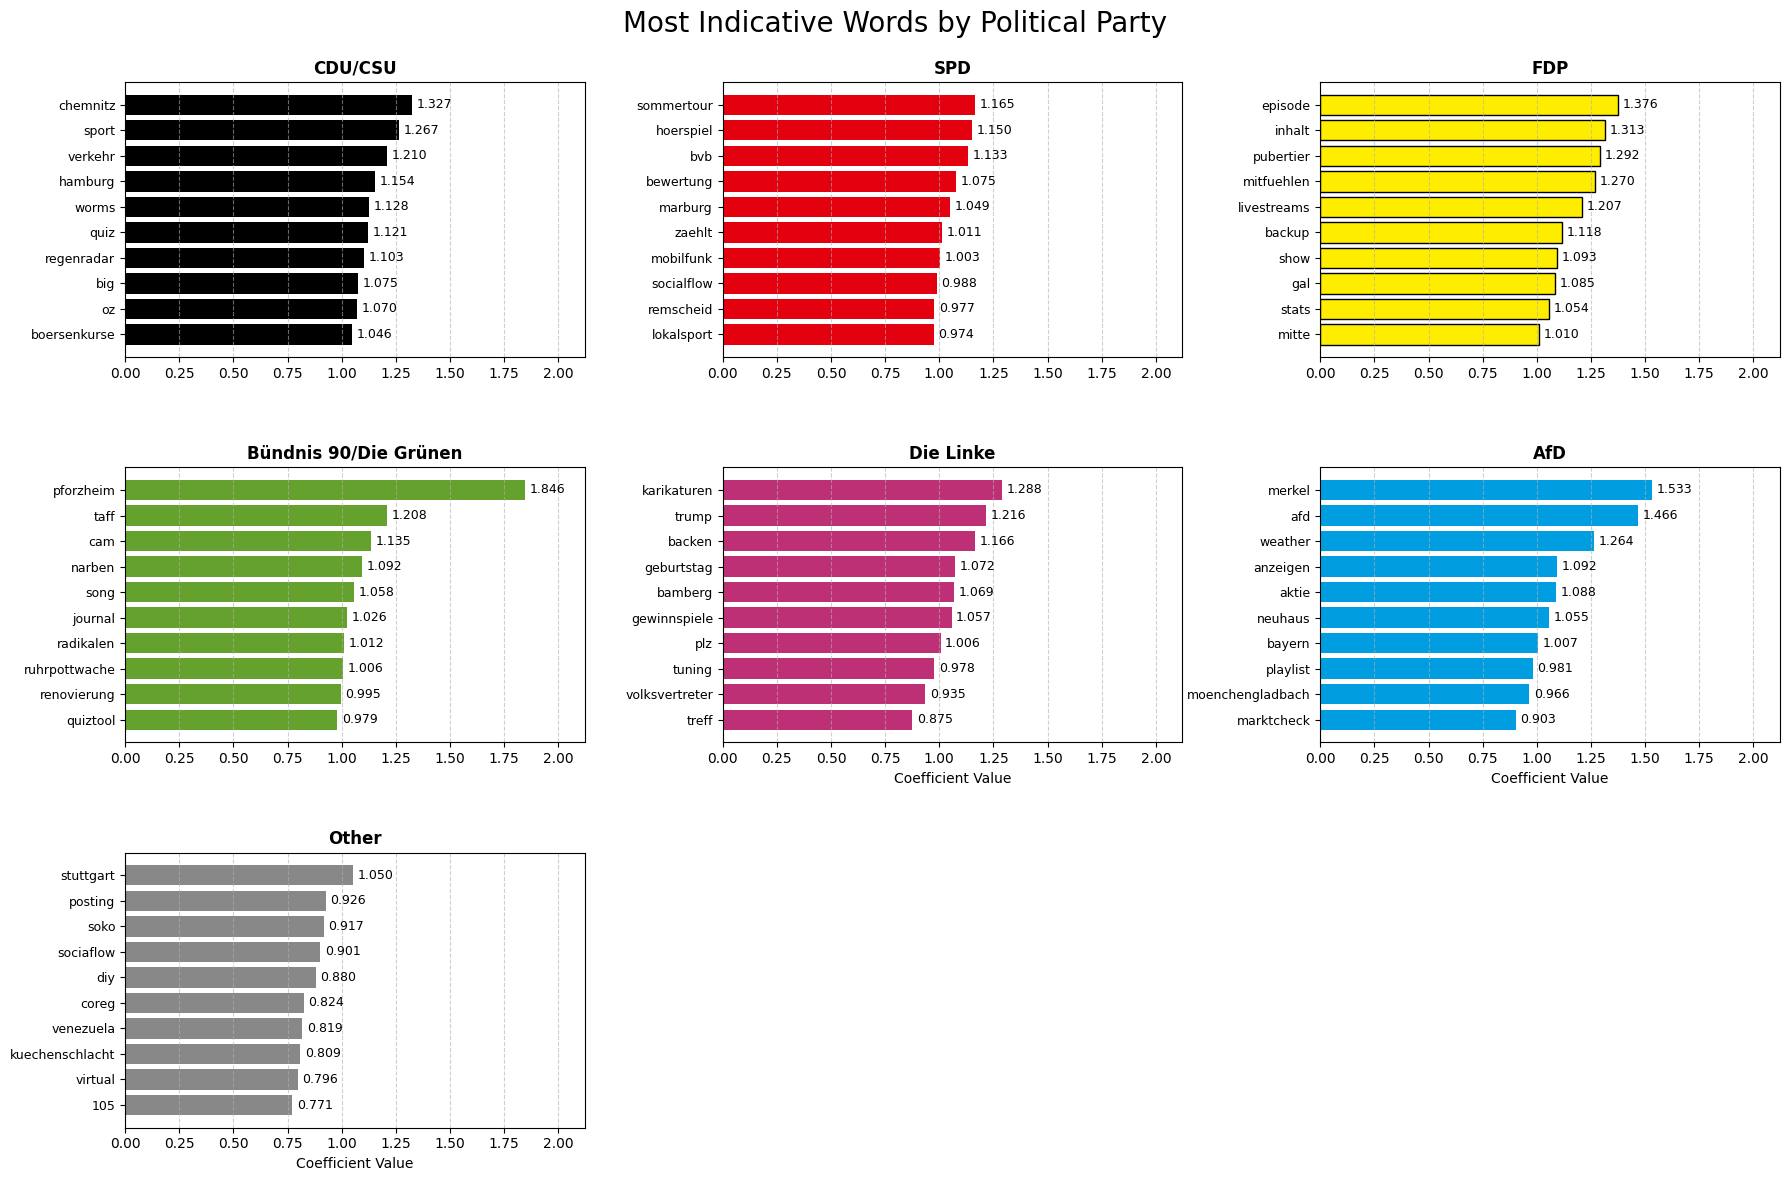

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Define party information with colors
party_label = {
    1: {'name': 'CDU/CSU', 'color': '#000000'},  # Black
    2: {'name': 'SPD', 'color': '#E3000F'},      # Red
    3: {'name': 'FDP', 'color': '#FFED00'},       # Yellow
    4: {'name': 'Bündnis 90/Die Grünen', 'color': '#64A12D'},  # Green
    5: {'name': 'Die Linke', 'color': '#BE3075'}, # Purple
    6: {'name': 'AfD', 'color': '#009EE0'},       # Blue
    7: {'name': 'Other', 'color': '#888888'},     # Gray
}

def plot_party_word_coefficients_grid(feature_names, coefficients, party_label, n_words=10, figsize=(18, 12)):
    """
    Create a grid of bar charts for each political party showing their most indicative words.
    
    Parameters:
    -----------
    feature_names : list[str]
        Names of features (words)
    coefficients : np.ndarray
        Coefficients from SVC model (shape: [n_classes, n_features])
        MUST be in same order as party_label keys
    party_label : dict
        Dictionary with party information {party_id: {'name': str, 'color': str}}
        Keys must match the order of classes in your model
    n_words : int, default=10
        Number of top words to show per party
    figsize : tuple, default=(18, 12)
        Figure size
    """
    # Get ordered list of parties from your label dict
    party_ids = sorted(party_label.keys())
    n_parties = len(party_ids)
    
    # Verify alignment
    if n_parties != len(coefficients):
        raise ValueError(f"Number of parties ({n_parties}) doesn't match coefficients shape ({len(coefficients)})")
    
    # Calculate grid layout
    n_cols = min(3, n_parties)
    n_rows = math.ceil(n_parties / n_cols)
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Most Indicative Words by Political Party', fontsize=20, y=0.98)
    
    # Flatten axes if needed
    axes = np.array(axes).flatten()
    
    # Find global maximum for consistent x-axis
    global_max = max(np.max(coef) for coef in coefficients)
    x_limit = global_max * 1.15
    
    # Plot each party
    for idx, party_id in enumerate(party_ids):
        ax = axes[idx]
        party_info = party_label[party_id]
        
        # Get top words and coefficients
        coefs = coefficients[idx]
        top_indices = np.argsort(coefs)[-n_words:]
        top_words = [feature_names[i] for i in top_indices]
        top_coeffs = coefs[top_indices]
        
        # Sort ascending for horizontal bars
        sort_order = np.argsort(top_coeffs)
        top_words = [top_words[i] for i in sort_order]
        top_coeffs = top_coeffs[sort_order]
        
        # Create bars
        bars = ax.barh(range(n_words), top_coeffs, 
                      color=party_info['color'],
                      edgecolor='black' if party_info['color'] == '#FFED00' else None)
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.01*x_limit, bar.get_y() + bar.get_height()/2,
                   f'{width:.3f}', 
                   ha='left', va='center',
                   fontsize=9,
                   color='black' if party_info['color'] == '#FFED00' else 'black')
        
        # Formatting
        ax.set_title(party_info['name'], fontsize=12, fontweight='bold')
        ax.set_yticks(range(n_words))
        ax.set_yticklabels(top_words, fontsize=9)
        ax.set_xlim(0, x_limit)
        ax.grid(axis='x', linestyle='--', alpha=0.6)
        
        # Only label bottom row
        if idx >= n_parties - n_cols:
            ax.set_xlabel('Coefficient Value', fontsize=10)
    
    # Hide unused axes
    for j in range(n_parties, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, wspace=0.3, hspace=0.4)
    plt.show()

plot_party_word_coefficients_grid(feature_names, coefficients, party_label)

In [37]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation
cv_scores = cross_val_score(svc, X, y_sv, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation accuracy: 0.1868 ± 0.0352


### Attempting to check with TF-IDF words are important based on ideology

In [38]:
# Transform the `left_right` column to be 0, 1, 2 instead of -1, 0, 1
news['left_right'] = news['left_right'].map({0:0, 1:1, -1: 2})

In [39]:
y_lr = news['left_right'] 

In [40]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_lr, test_size=0.2, random_state=42, stratify=y_lr
)

# Train a Linear SVC
svc = LinearSVC(
    C=1.0,
    class_weight='balanced',
    dual=False,
    max_iter=10000
)

# Train the model
svc.fit(X_train, y_train)

# Make predictions
y_pred = svc.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.06      0.09        48
           1       0.46      0.44      0.45       103
           2       0.48      0.63      0.54       118

    accuracy                           0.45       269
   macro avg       0.37      0.38      0.36       269
weighted avg       0.42      0.45      0.43       269



In [41]:
# Use your existing left-right party_label
party_label = {
    2: {'name': 'Left Wing', 'color': '#E3000F'},
    1: {'name': 'Right Wing', 'color': '#009EE0'}, 
    0: {'name': 'Unknown', 'color': '#CCCCCC'}
}

# Get coefficients from your trained SVC
coefficients = svc.coef_  # Shape will be (3, n_features) for -1,0,1

def plot_party_word_coefficients_grid(feature_names, coefficients, party_label, class_order, n_words=10, figsize=(18, 12)):
    """
    Create correctly aligned bar charts for political groups.
    
    Parameters:
    -----------
    feature_names : list[str]
        Names of features (words)
    coefficients : np.ndarray
        Coefficients from SVC model (shape: [n_classes, n_features])
    party_label : dict
        Dictionary with party information {party_id: {name: str, color: str}}
    class_order : list
        The order of classes as used by your model (e.g., [-1, 0, 1])
    n_words : int, default=10
        Number of top words to show per group
    figsize : tuple, default=(18, 12)
        Figure size
    """
    # Verify alignment
    if len(class_order) != len(coefficients):
        raise ValueError(f"Class order length ({len(class_order)}) doesn't match coefficients shape ({len(coefficients)})")
    
    # Calculate grid dimensions
    n_parties = len(class_order)
    n_cols = min(3, n_parties)
    n_rows = math.ceil(n_parties / n_cols)
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Most Indicative Words by Political Group', fontsize=20, y=0.98)
    
    # Flatten axes
    axes = np.array(axes).flatten()
    
    # Find global maximum
    global_max = max(np.max(np.abs(coef)) for coef in coefficients)
    x_limit = global_max * 1.15
    
    # Plot each party with explicit mapping
    for idx, class_id in enumerate(class_order):
        ax = axes[idx]
        party_info = party_label[class_id]
        
        # Get coefficients for this class
        party_coeffs = coefficients[idx]
        
        # Get top words
        top_indices = np.argsort(party_coeffs)[-n_words:]
        top_words = [feature_names[i] for i in top_indices]
        top_coeffs = party_coeffs[top_indices]
        
        # Sort for display
        sort_order = np.argsort(top_coeffs)
        top_words = [top_words[i] for i in sort_order]
        top_coeffs = top_coeffs[sort_order]
        
        # Create bars
        bars = ax.barh(range(n_words), top_coeffs, 
                      color=party_info['color'],
                      edgecolor='black')
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.01*x_limit, bar.get_y() + bar.get_height()/2,
                   f'{width:.3f}', 
                   ha='left', va='center',
                   fontsize=8)
        
        # Formatting
        ax.set_title(party_info['name'], fontsize=12, fontweight='bold')
        ax.set_yticks(range(n_words))
        ax.set_yticklabels(top_words, fontsize=9)
        ax.set_xlim(0, x_limit)
        ax.grid(axis='x', linestyle='--', alpha=0.6)
        
        if idx >= n_parties - n_cols:
            ax.set_xlabel('Coefficient Value', fontsize=10)
    
    # Hide unused axes
    for j in range(n_parties, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, wspace=0.3, hspace=0.4)
    plt.show()

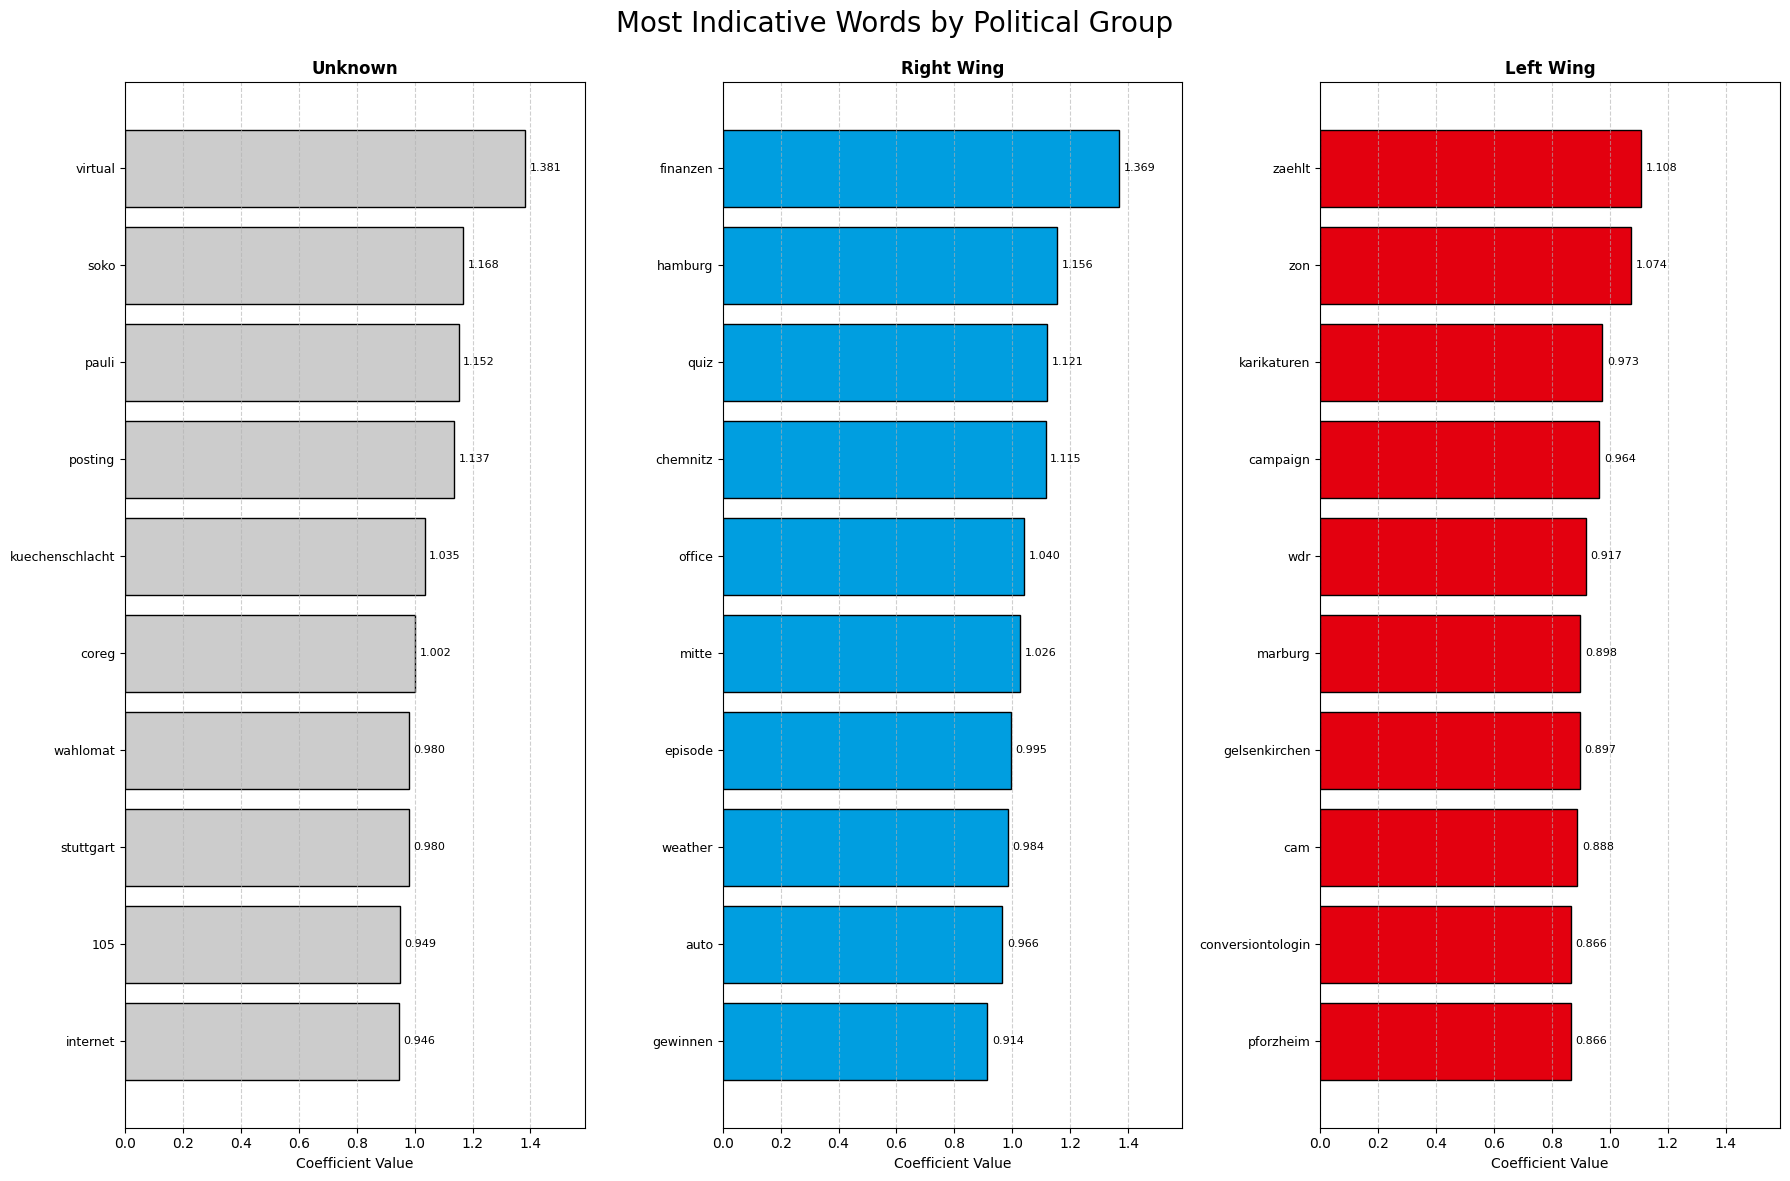

In [42]:

plot_party_word_coefficients_grid(
    feature_names,
    coefficients,
    party_label,
    class_order=[0, 1, 2]  # Must match svc.classes_ order!
)


In [43]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation
cv_scores = cross_val_score(svc, X, y_lr, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation accuracy: 0.3957 ± 0.1084


## Linear SVC but with columns & TF-IDF Aggregation

In [44]:
news.columns 

Index(['personid', 'duration', 'text_clean', 'secondvote', 'vote_left',
       'vote_green', 'vote_spd', 'vote_na_other', 'vote_fdp', 'vote_cdu',
       'vote_afd', 'news_proportion', 'age', 'ml_gender_female', 'ml_married',
       'ml_relationship', 'ml_employ', 'ml_degreestatus',
       'ml_political_interest', 'adjustedvote', 'polinterest',
       'adjustedincome', 'fgender', 'fvoceduc', 'frelationship',
       'fmaritalstatus', 'femployment', 'tf_idf_mean',
       'tf_idf_entity_weighted', 'tf_idf_importance_weighted', 'left_right'],
      dtype='object')

In [45]:
import pandas as pd

# Assuming 'news' is your DataFrame

# Check which columns have any NA values
columns_with_na = news.isna().any()

# Filter to get the columns that have any NA values (where True)
df_with_na_columns = news.loc[:, columns_with_na]

# Output the result
print(df_with_na_columns)


      duration
0     111731.0
1       5429.0
2       1317.0
3       1548.0
4        792.0
...        ...
1339       NaN
1340       NaN
1341       NaN
1342       NaN
1343       NaN

[1344 rows x 1 columns]


In [46]:
# Set all NA values in the DataFrame to 0
news = news.fillna(0)


Attempting with just (semi) continuous variables.

In [47]:

# Define predictors (y variables)
predictors = ["left_right"]

# Feature sets
features_list = [
    'duration', 'news_proportion', 'age', 'ml_gender_female', 'ml_married', 'ml_relationship',
    'ml_employ', 'ml_degreestatus', 'ml_political_interest', 'polinterest', 'adjustedincome']

must_include_list = ['tf_idf_mean', 'tf_idf_entity_weighted', 'tf_idf_importance_weighted']

# Identify categorical and continuous features
categorical_features = ['polinterest', 'adjustedincome'] 
continuous_features = ['duration', 'news_proportion', 'age'] + must_include_list

# Generate feature subsets ensuring at least one 'must_include' feature is present
feature_combinations = []
for r in range(1, len(features_list) + 1):
    for subset in itertools.combinations(features_list, r):
        for must_include in must_include_list:
            feature_combinations.append(list(subset) + [must_include])

# Remove duplicates and ensure valid features only
feature_combinations = [list(set(fc)) for fc in feature_combinations]
feature_combinations = [list(fc) for fc in set(tuple(sorted(fc)) for fc in feature_combinations)]

# Track results
results = []

# Train models for each feature combination and predictor
for y_var in predictors:
    for feature_set in feature_combinations:
        # Ensure selected features exist in the dataset
        valid_features = [feat for feat in feature_set if feat in news.columns]
        X = news[valid_features]
        y = news[y_var]

        # Encode categorical target
        y = (y == y.unique()[1]).astype(int)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Preprocessing pipeline
        preprocessor = ColumnTransformer(transformers=[
            ('num', StandardScaler(), [feat for feat in valid_features if feat in continuous_features]),
            ('cat', OneHotEncoder(handle_unknown='ignore'), [feat for feat in valid_features if feat in categorical_features])
        ])


        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LinearSVC(dual=False, max_iter=5000, class_weight='balanced'))
        ])

        # Train model
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # Store results
        results.append((y_var, valid_features, f1, precision, recall, accuracy))

# Sort and get top 5 results
top_5_results = sorted(results, key=lambda x: x[2], reverse=True)

# Convert to DataFrame and display
top_5_df = pd.DataFrame(top_5_results, columns=['Predictor', 'Features', 'F1 Score', 'Precision', 'Recall', 'Accuracy'])



In [72]:
top_5_df.sort_values(by='F1 Score', ascending=False).head()

,Predictor,Features,F1 Score,Precision,Recall,Accuracy
0,left_right,"[adjustedincome, ml_degreestatus, news_proport...",0.537313,0.48,0.610169,0.539033
33,left_right,"[adjustedincome, ml_employ, ml_married, ml_pol...",0.537313,0.48,0.610169,0.539033
35,left_right,"[adjustedincome, ml_degreestatus, ml_employ, m...",0.537313,0.48,0.610169,0.539033
36,left_right,"[adjustedincome, ml_degreestatus, ml_gender_fe...",0.537313,0.48,0.610169,0.539033
37,left_right,"[adjustedincome, ml_gender_female, ml_politica...",0.537313,0.48,0.610169,0.539033


In [69]:
# Filter rows where 'Features' contains 'tf_idf_entity_weighted'
filtered_df = top_5_df[top_5_df['Features'].apply(lambda x: 'tf_idf_entity_weighted' in x)]
filtered_df_sorted = filtered_df.sort_values(by='F1 Score', ascending=False)
filtered_df_sorted.head()


,Predictor,Features,F1 Score,Precision,Recall,Accuracy
128,left_right,"[adjustedincome, duration, ml_degreestatus, ml...",0.534351,0.486111,0.59322,0.546468
192,left_right,"[adjustedincome, duration, ml_degreestatus, ml...",0.534351,0.486111,0.59322,0.546468
202,left_right,"[adjustedincome, duration, ml_degreestatus, ml...",0.534351,0.486111,0.59322,0.546468
204,left_right,"[adjustedincome, duration, ml_degreestatus, ml...",0.534351,0.486111,0.59322,0.546468
206,left_right,"[adjustedincome, duration, ml_gender_female, m...",0.534351,0.486111,0.59322,0.546468


In [70]:
list(filtered_df_sorted['Features'][0:1])

[['adjustedincome',
  'duration',
  'ml_degreestatus',
  'ml_gender_female',
  'ml_married',
  'ml_relationship',
  'news_proportion',
  'polinterest',
  'tf_idf_entity_weighted']]

The below seems to suggest that importance_weighted comes off slightly higher in terms of F1 scores

In [67]:
# Filter rows where 'Features' contains 'tf_idf_entity_weighted'
filtered_df2 = top_5_df[top_5_df['Features'].apply(lambda x: 'tf_idf_importance_weighted' in x)]

filtered_df2_sorted = filtered_df2.sort_values(by='F1 Score', ascending=False)
filtered_df2_sorted.head()

,Predictor,Features,F1 Score,Precision,Recall,Accuracy
0,left_right,"[adjustedincome, ml_degreestatus, news_proport...",0.537313,0.48,0.610169,0.539033
33,left_right,"[adjustedincome, ml_employ, ml_married, ml_pol...",0.537313,0.48,0.610169,0.539033
35,left_right,"[adjustedincome, ml_degreestatus, ml_employ, m...",0.537313,0.48,0.610169,0.539033
36,left_right,"[adjustedincome, ml_degreestatus, ml_gender_fe...",0.537313,0.48,0.610169,0.539033
37,left_right,"[adjustedincome, ml_gender_female, ml_politica...",0.537313,0.48,0.610169,0.539033


In [68]:
list(filtered_df2_sorted['Features'][0:1])

[['adjustedincome',
  'ml_degreestatus',
  'news_proportion',
  'polinterest',
  'tf_idf_importance_weighted']]

Just checking to see where the accuracies from above falls

In [75]:
top_5_df['Accuracy'].sort_values(ascending=False)

480     0.550186
451     0.550186
442     0.550186
443     0.550186
444     0.550186
          ...   
3561    0.486989
3560    0.486989
3559    0.486989
3558    0.486989
3568    0.486989
Name: Accuracy, Length: 6141, dtype: float64